#### Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import re
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import math

#### Business Questions to Find answers to

Question I want to provide answers to:
 - What are the most popular Airbnb destinations?
 - What factors influence cost of Airbnb rental costs?
 - What contributes to good Airbnb ratings?
 - Does cancelation policy affect reviews?

#### Data Understanding:

In [2]:
listings = pd.read_csv("seattle/listings.csv")
print("\nShape of dataset: ",listings.shape,"\n")
listings.head(3)


Shape of dataset:  (3818, 92) 



,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15


In [3]:
listings.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,calculated_host_listings_count,reviews_per_month
count,3.818000e+03,3.818000e+03,3.818000e+03,3816.000000,3816.000000,3818.000000,3818.000000,3818.000000,3802.000000,3812.000000,...,3171.000000,3160.000000,3165.000000,3160.000000,3167.000000,3163.000000,3162.000000,0.0,3818.000000,3191.000000
mean,5.550111e+06,2.016010e+13,1.578556e+07,7.157757,7.157757,47.628961,-122.333103,3.349398,1.259469,1.307712,...,94.539262,9.636392,9.556398,9.786709,9.809599,9.608916,9.452245,NaN,2.946307,2.078919
std,2.962660e+06,0.000000e+00,1.458382e+07,28.628149,28.628149,0.043052,0.031745,1.977599,0.590369,0.883395,...,6.606083,0.698031,0.797274,0.595499,0.568211,0.629053,0.750259,NaN,5.893029,1.822348
min,3.335000e+03,2.016010e+13,4.193000e+03,1.000000,1.000000,47.505088,-122.417219,1.000000,0.000000,0.000000,...,20.000000,2.000000,3.000000,2.000000,2.000000,4.000000,2.000000,NaN,1.000000,0.020000
25%,3.258256e+06,2.016010e+13,3.275204e+06,1.000000,1.000000,47.609418,-122.354320,2.000000,1.000000,1.000000,...,93.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,NaN,1.000000,0.695000
50%,6.118244e+06,2.016010e+13,1.055814e+07,1.000000,1.000000,47.623601,-122.328874,3.000000,1.000000,1.000000,...,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,1.000000,1.540000
75%,8.035127e+06,2.016010e+13,2.590309e+07,3.000000,3.000000,47.662694,-122.310800,4.000000,1.000000,2.000000,...,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,2.000000,3.000000
max,1.034016e+07,2.016010e+13,5.320861e+07,502.000000,502.000000,47.733358,-122.240607,16.000000,8.000000,7.000000,...,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,37.000000,12.150000


In [4]:
""" 
The output from this cell reveals there are a number of columns/rows 
that have nan/null values and hence require dropping(removing).
"""
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

#### Data Cleaning

The dataset has way so many features and not all of them are relevant for the analysis we want to do. This means we have to drop some columns(features) and rows however we'll need a good reason for each drop. 
I have listed categories of reasons and how to identify what to drop below:<br/>
<ol>
<li>Columns with non-unique values: These columns have a single repeated for all the rows of that columns and hence they do not add anything significant to the dataset.</li><br/>
<li>Rows that have about 70% of values as Nan, None or empty strings: 70% is a huge chunk of the dataset that we cannot impute data for and wouldn't make sense to maintain</li><br/>
</ol>

Having followed thr above process will reduce the features to 80 from 92.

In [5]:
# Calculate the threshold count for dropping columns
threshold_col = len(listings) * 0.7

# Replace empty and "none" values with NaN
listings_replaced = listings.replace(['', 'none'], np.nan)

# Count the number of NaN values in each column
na_counts = listings_replaced.isna().sum()

# Get the column indices where the count exceeds or equals the threshold
columns_to_drop_1 = na_counts[na_counts >= threshold_col].index

# Drop the columns
listings = listings_replaced.drop(columns=columns_to_drop_1)

# Get the unique value counts for each column
value_counts = listings.nunique()

# Get the column names where all values are the same
columns_to_drop_2 = value_counts[value_counts == 1].index

# Drop the non-unique columns of this dataset
listings = listings.drop(columns=columns_to_drop_2)
columns_to_drop = columns_to_drop_1.to_list() + columns_to_drop_2.to_list()
print("Dropped columns are :", columns_to_drop)
print("listings shape: ", listings.shape)
listings.head(3)

Dropped columns are : ['experiences_offered', 'square_feet', 'license', 'scrape_id', 'last_scraped', 'market', 'country_code', 'country', 'has_availability', 'calendar_last_scraped', 'requires_license', 'jurisdiction_names']
listings shape:  (3818, 80)


,id,listing_url,name,summary,space,description,neighborhood_overview,notes,transit,thumbnail_url,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,NaN,NaN,NaN,NaN,...,10.0,10.0,9.0,10.0,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,...,10.0,10.0,10.0,10.0,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,Upper Queen Anne is a charming neighborhood fu...,Our house is located just 5 short blocks to To...,A bus stop is just 2 blocks away. Easy bus a...,NaN,...,10.0,10.0,10.0,10.0,f,strict,f,f,2,1.15


The code below will print out all the columns of the dataset.
You can go through them manually to identify which features are most relevant to our analysis and which aren't.
This way we can drop more features and have a more meaningful dataset to work with.
<br/>

This could mean checking out each column to know what datatype type it is and if the value thereof is relevant. 
You'll find out that most of the Ids are not relevant for the analysis we want to make. Also some other columns like summary, description, space and other features where we are mostly dealing with texts/urls that can't be grouped into some sort of categorical variables need to be dropped as well because they are all unique for each and every role of that columns and hence doesn't pose anything interesting to study or analyse.

In [14]:
# Set the display options to show all columns
# pd.set_option('display.max_columns', None)
# pd.set_option('display.expand_frame_repr', False)

# Print the column names
print(listings.columns)

Index(['id', 'listing_url', 'name', 'summary', 'space', 'description',
       'neighborhood_overview', 'notes', 'transit', 'thumbnail_url',
       'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode',
       'smart_location', 'latitude', 'longitude', 'is_location_exact',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'bed_type', 'amenities', 'price', 'weekly_price',
       'monthly_price', 'security_deposit', 'cleaning_fee', 'gues

### Feature Selection & Visualizations:

In [21]:
# Select the columns of interest, including 'price'

columns_of_interest = [
    'host_is_superhost',
    'neighbourhood_cleansed',
    'accommodates',
    'bedrooms',
    'bathrooms',
    'is_location_exact',
    'review_scores_rating',
    'property_type',
    'room_type',
    'beds',
    'bed_type',
    'number_of_reviews',
    'instant_bookable',
    'review_scores_accuracy',
    'review_scores_cleanliness',
    'review_scores_communication',
    'review_scores_value',
    'cancellation_policy',
    'availability_365',
    'price'
]

len(columns_of_interest)

20

#### Heapmap showing correlation between selected non-categotical features

/var/folders/h8/n2whn8ld5zggrq_zdkp65p_00000gn/T/ipykernel_35322/1387308684.py:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = listings_relevant.corr()


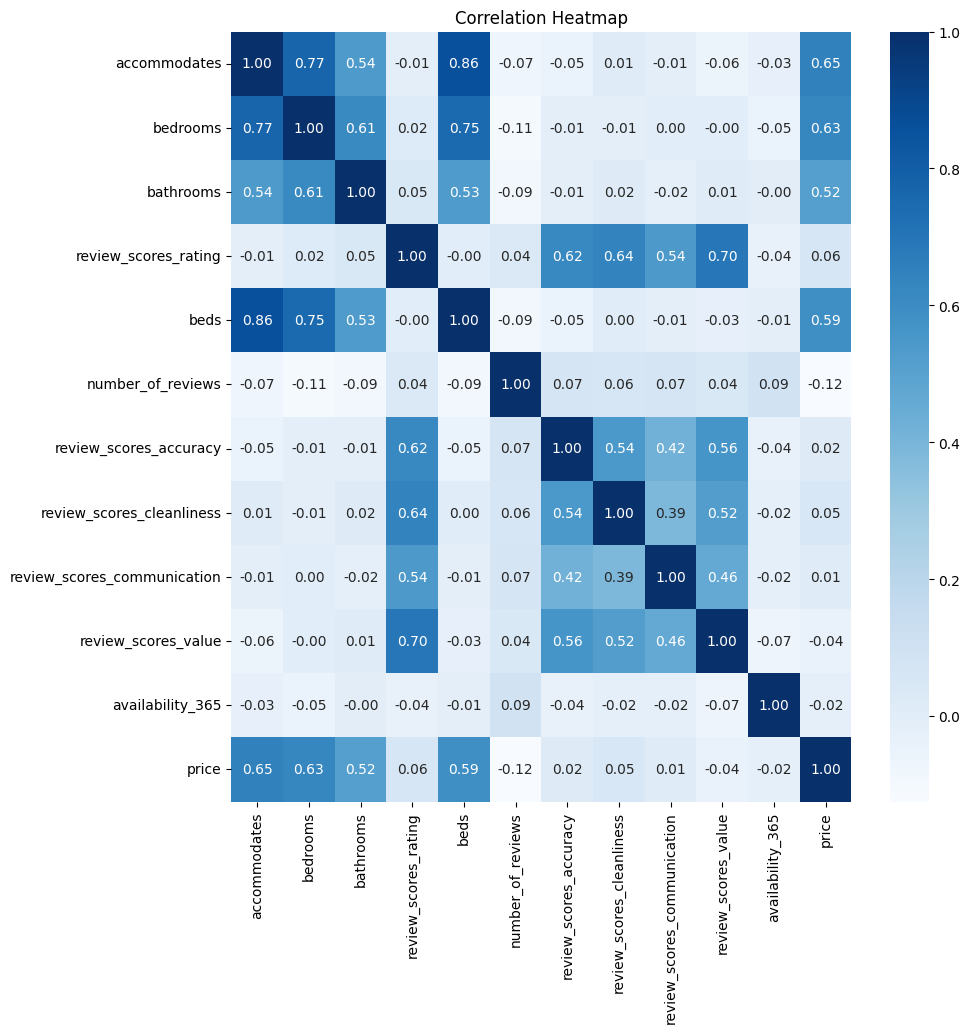

In [23]:
# Subset the data to include only the columns of interest
listings_relevant = listings.loc[:, columns_of_interest]

# Remove non-numeric characters from the 'pricing' column
listings_relevant['price'] = listings_relevant['price'].apply(lambda x: re.sub(r'[^\d.]+', '', str(x))).astype(float)

# Calculate the correlation matrix
correlation_matrix = listings_relevant.corr()

# Visualize the correlations using a heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, cmap='Blues', annot=True, fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

Out of the 20 features, only 12 were accounted for in the heapmap above because the remaining values are categorical and need to be treated differently.

### Dealing with categorical variables & improperly represented Boolean Variables in the listings dataset:

This is still some part of the data cleaning process as we still do not have the dataset in the format it should be before completely anlysing. A few things:</br>
<ol>
<li>There are boolean values represent as strings in the form of 't' or 'f'. These should be replace with actual Boolean values of 0 and 1.</li>
<li></li>
</ol>


In [ ]:
# Identify columns containing 'f' or 't' values
boolean_cols = [col for col in listings_relevant if listings[col].isin(['f','t', np.nan]).all()]

# Convert 'f' to False and 't' to True in the identified columns
listings_relevant[boolean_cols] = listings_relevant[boolean_cols].replace({'f': False, 't': True})

#Remove all the nan values in the dataset and convert the True/False values to 0/1:
listings_relevant = listings_relevant.dropna(subset=[b for b in boolean_cols]).astype({b: int for b in boolean_cols})

In [ ]:
# Remove non-numeric characters from the 'pricing' column
listings_relevant['price'] = listings_relevant['price'].apply(lambda x: re.sub(r'[^\d.]+', '', str(x)))

# Select the variables to normalize and plot against the price
variables_to_plot = ['host_is_superhost', 'is_location_exact', 'property_type',
                     'room_type', 'bed_type', 'instant_bookable', 
                     'cancellation_policy','neighbourhood_cleansed']

# Group by each column and plot against the price
for column in variables_to_plot:
    status_city = listings_relevant[column].value_counts()
    (status_city/listings_relevant.shape[0]).plot(kind="bar");
    plt.xlabel(column)
    plt.title(f'Value count of {column}')
    plt.show()

In [ ]:
# Remove non-numeric characters from the 'price' column
listings_relevant['price'] = listings_relevant['price'].apply(lambda x: re.sub(r'[^\d.]+', '', str(x)))

# Select the variables to normalize and plot against the price
variables_to_plot = ['host_is_superhost', 'is_location_exact', 'property_type',
                     'room_type', 'bed_type', 'instant_bookable',
                     'cancellation_policy', 'neighbourhood_cleansed']

# Calculate the number of rows and columns for the subplots
n_plots = len(variables_to_plot)
n_rows = math.ceil(n_plots / 2)
n_cols = 2
# Create the subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 30))

# Iterate over the variables and create the subplots
for i, column in enumerate(variables_to_plot):
    row = i // n_cols
    col = i % n_cols

    # Plot the value counts
    status_city = listings_relevant[column].value_counts()
    (status_city / listings_relevant.shape[0]).plot(kind="bar", ax=axes[row, col])
    axes[row, col].set_xlabel(column)
    axes[row, col].set_ylabel('Frequency')
    axes[row, col].set_title(f'Value count of {column}')

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.5, wspace=0.3)  # Increase the spacing between subplots

# Show the plots
plt.show()

In [ ]:
# Convert the 'price' column to float
listings_relevant['price'] = listings_relevant['price'].astype(float)
# Define the columns to group by
group_by_columns = ['host_is_superhost', 'is_location_exact', 'property_type',
'room_type', 'bed_type', 'instant_bookable', 'cancellation_policy']

for col in group_by_columns:

    # Group the data by the specified columns and calculate the average pricing
    grouped_data = listings_relevant.groupby(col)['price'].mean()

    # Reset the index to flatten the grouped data
    grouped_data = grouped_data.reset_index()

    # Plot the grouped data
    plt.figure(figsize=(10, 6))
    sns.barplot(data=grouped_data, x=col, y='price', palette='viridis')
    plt.xlabel(f'{col}')
    plt.ylabel('Average Pricing')
    plt.title(f'Average Pricing by {col}')
    plt.legend(title= f'Pricing based on {col} grouping')
    plt.legend(labels=['Data'])


    # Get the x-axis tick labels
    x_ticks_labels = plt.gca().get_xticklabels()
    # Slant the x-axis tick labels by the specified angle
    plt.gca().set_xticklabels(x_ticks_labels, rotation=90)
    plt.show()


In [ ]:
type(listings_relevant['price'].astype(float))

In [ ]:
for col in listings_relevant:
    status_city = listings_relevant[col].value_counts()
    (status_city/listings_relevant.shape[0]).plot(kind="bar");
    plt.show()

In [ ]:
sum(listings_relevant['review_scores_value'].isna())

In [ ]:
listings_relevant['city'].unique()

In [ ]:
listings_relevant['host_is_superhost'].unique()

In [ ]:
print("\n".join([f"{column} : {listings_relevant[column].nunique()}" for column in listings_relevant.select_dtypes(exclude=['int']).columns]))

In [ ]:
sum(listings_relevant['host_acceptance_rate'].isna())

In [ ]:
listings_relevant

In [ ]:
# Step 4: Standardize numeric columns
numeric_columns = listings_relevant.select_dtypes(include=['float', 'int']).columns

# Create a StandardScaler object
scaler = StandardScaler()

# Fit and transform the numeric columns
listings_relevant[numeric_columns] = scaler.fit_transform(listings_relevant[numeric_columns])

In [ ]:
listings_relevant

In [ ]:
reviews = pd.read_csv("seattle/reviews.csv")
reviews.head()

In [ ]:
calendar = pd.read_csv("seattle/calendar.csv")
calendar.head(3)

In [ ]:
merged_1 = pd.merge(reviews, calendar, on='listing_id')
merged_1.head()

Only an approximation of 33% of the pricing dataset is Nan. We can exclude this from the dataset and make use with the remaining 67%. <br/> <br/>
The remaining columns in the calendar file do not have Nan values. However, there is common column names "date" in the calendar csv file and the reviews csv file. You may one to rename both as they do not represent the same kind of date.

In [ ]:
print(calendar['price'].isna().sum()/calendar.shape[0])
# Removing Nans from the pricing column:
calendar = calendar.dropna().reindex()
calendar.head(3)